# Relative Reconstruction Error

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from pathlib import Path

from core.mesh_data import DataModule
from core.PVCAE.model import Model

In [2]:
data_path = Path('../data/flow_mesh')
model_path = Path('../lightning_logs/flow/pvcae/version_0/checkpoints/')
model_path = list(model_path.glob('epoch=*.ckpt'))[0]

In [3]:
#update per experiment
kwargs = {
    'vox_size': [0.02,0.02],

    'conv_params': {"in_channels":[1,8],
                    "out_channels":[8,16],
                    "kernel_size":[3],
                    "bias":[False],
                    "padding": ["same"]},

    'point_params': {"in_channels":[1,2],
                "out_channels":[2,2],
                "bias":[False]}
}

In [4]:
#data module
dm = DataModule(data_dir=data_path,
                spatial_dim=2,
                num_points=7613,
                batch_size=128,
                channels=[0])

#trainer
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=False)

#model
model = Model.load_from_checkpoint(model_path,
                                  data_info=dm.get_data_info(),
                                  **kwargs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
out = trainer.test(model=model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_avg_err          1.0203595161437988
      test_max_err           1.026322841644287
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Images/GIFs

In [6]:
import gif
import matplotlib.pyplot as plt

In [7]:
pred = trainer.predict(model=model, datamodule=dm)
pred = dm.agglomerate(pred)
pred = pred.squeeze()
print(pred.shape)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

torch.Size([300, 7613])


In [8]:
plot_func = dm.get_plot_func()

## Make GIF

In [8]:
@gif.frame
def plot(i):
    fig, ax = plt.subplots(1, 2)

    plot_func(dm.get_sample(i), ax[0])
    ax[0].set_title("Uncompressed")

    im = plot_func(pred[i,...], ax[1])
    ax[1].set_title("Reconstructed")

    if dm.spatial_dim == 2:
        # mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        fig.colorbar(im, ax=ax.ravel().tolist(), location='bottom')

In [9]:
#build frames
frames = [plot(i) for i in range(pred.shape[0])]

#save gif
gif.save(frames, "best.gif", duration=50)

## Make Image

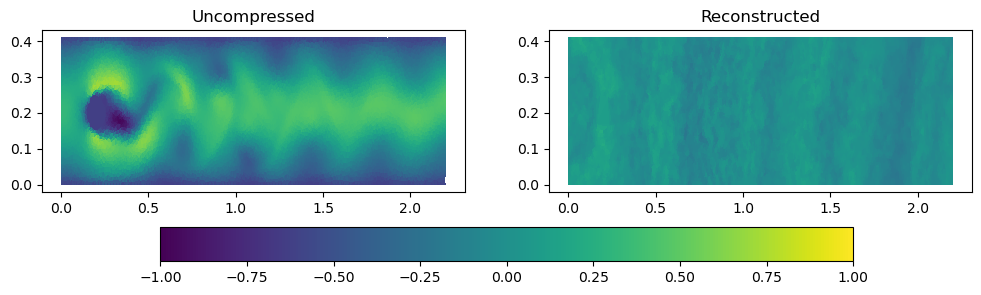

In [9]:
t = 60

fig, ax = plt.subplots(1, 2, figsize=(12,3))

plot_func(dm.get_sample(t), ax[0])
ax[0].set_title("Uncompressed")

im = plot_func(pred[t,...], ax[1])
ax[1].set_title("Reconstructed")

fig.colorbar(im, ax=ax.ravel().tolist(), location='bottom')

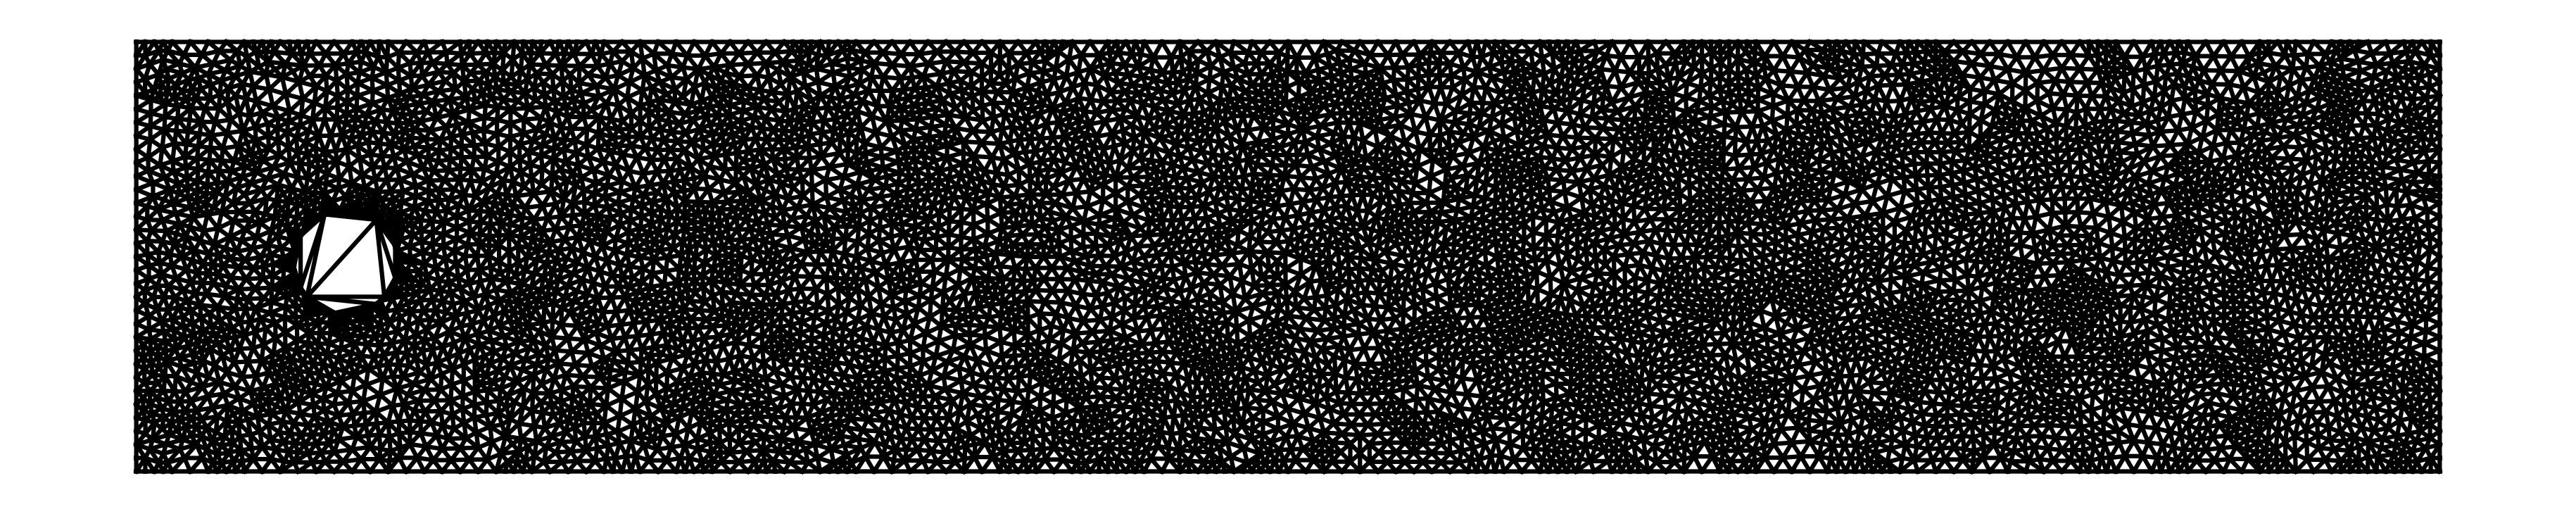

In [10]:
flow_tri = dm._triangulation

fig_tri = plt.figure(figsize=(12,3.8), dpi=300)

ax_tri = fig_tri.add_axes([0,0,1,1])

ax_tri.triplot(flow_tri, color='black')

ax_tri.axis('off')
ax_tri.set_aspect('equal')